In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 150)
sns.set_theme(style="whitegrid")

In [2]:
spark = SparkSession.builder.getOrCreate()
df = spark.read.parquet("../data/preprocessed/insurance_claims_clean.parquet")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/14 13:57:07 WARN Utils: Your hostname, MacBook-Air-Maryna.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.142 instead (on interface en0)
25/11/14 13:57:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/14 13:57:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df.printSchema()
df.describe().show()

root
 |-- subscription_length: double (nullable = true)
 |-- vehicle_age: double (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- region_code: string (nullable = true)
 |-- region_density: integer (nullable = true)
 |-- segment: string (nullable = true)
 |-- model: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- airbags: integer (nullable = true)
 |-- is_esc: integer (nullable = true)
 |-- is_adjustable_steering: integer (nullable = true)
 |-- is_tpms: integer (nullable = true)
 |-- is_parking_sensors: integer (nullable = true)
 |-- is_parking_camera: integer (nullable = true)
 |-- rear_brakes_type: string (nullable = true)
 |-- displacement: integer (nullable = true)
 |-- cylinder: integer (nullable = true)
 |-- transmission_type: string (nullable = true)
 |-- steering_type: string (nullable = true)
 |-- turning_radius: double (nullable = true)
 |-- length: integer (nullable = true)
 |-- width: intege

25/11/14 13:57:10 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+------------------+-----------+------------------+-------+-----+---------+-----------+------------------+------------------+----------------------+-------------------+-------------------+-------------------+----------------+------------------+-------------------+-----------------+-------------+-------------------+------------------+------------------+------------------+-------------------+--------------------+---------------------+-----------------------+------------------+-------------------+------------------+-------------------+--------------------------------+-----------------------------+------------------+-------------------+------------------+-------------------+------------------+-----------------+-----------------+-----------------+
|summary|subscription_length|       vehicle_age|      customer_age|region_code|    region_density|segment|model|fuel_type|engine_type|           airbags|            is_esc|is_adjustable_steering|     

### Target distribution check

In [4]:
df.groupBy("claim_status").count().show()


+------------+-----+
|claim_status|count|
+------------+-----+
|           1| 3748|
|           0|54844|
+------------+-----+



### Numerical features analysis

In [5]:
numeric_cols_viz = [
    "subscription_length", 
    "vehicle_age", 
    "customer_age", 
    "region_density", 
    "airbags", 
    "displacement", 
    "cylinder", 
    "turning_radius", 
    "length", 
    "width", 
    "gross_weight", 
    "ncap_rating", 
    "max_torque_nm", 
    "max_torque_rpm", 
    "max_power_bhp", 
    "max_power_rpm"]

df.select([F.mean(c).alias(c +"_mean") for c in numeric_cols_viz]).show()

+------------------------+------------------+------------------+-------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
|subscription_length_mean|  vehicle_age_mean| customer_age_mean|region_density_mean|     airbags_mean| displacement_mean|     cylinder_mean|turning_radius_mean|       length_mean|        width_mean| gross_weight_mean|  ncap_rating_mean|max_torque_nm_mean|max_torque_rpm_mean|max_power_bhp_mean|max_power_rpm_mean|
+------------------------+------------------+------------------+-------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
|       6.111687602403046|1.3884728290552057|44.8239350081

In [6]:
df_pd_num = df.select(numeric_cols_viz).sample(False, 0.3, seed=0.42).toPandas()

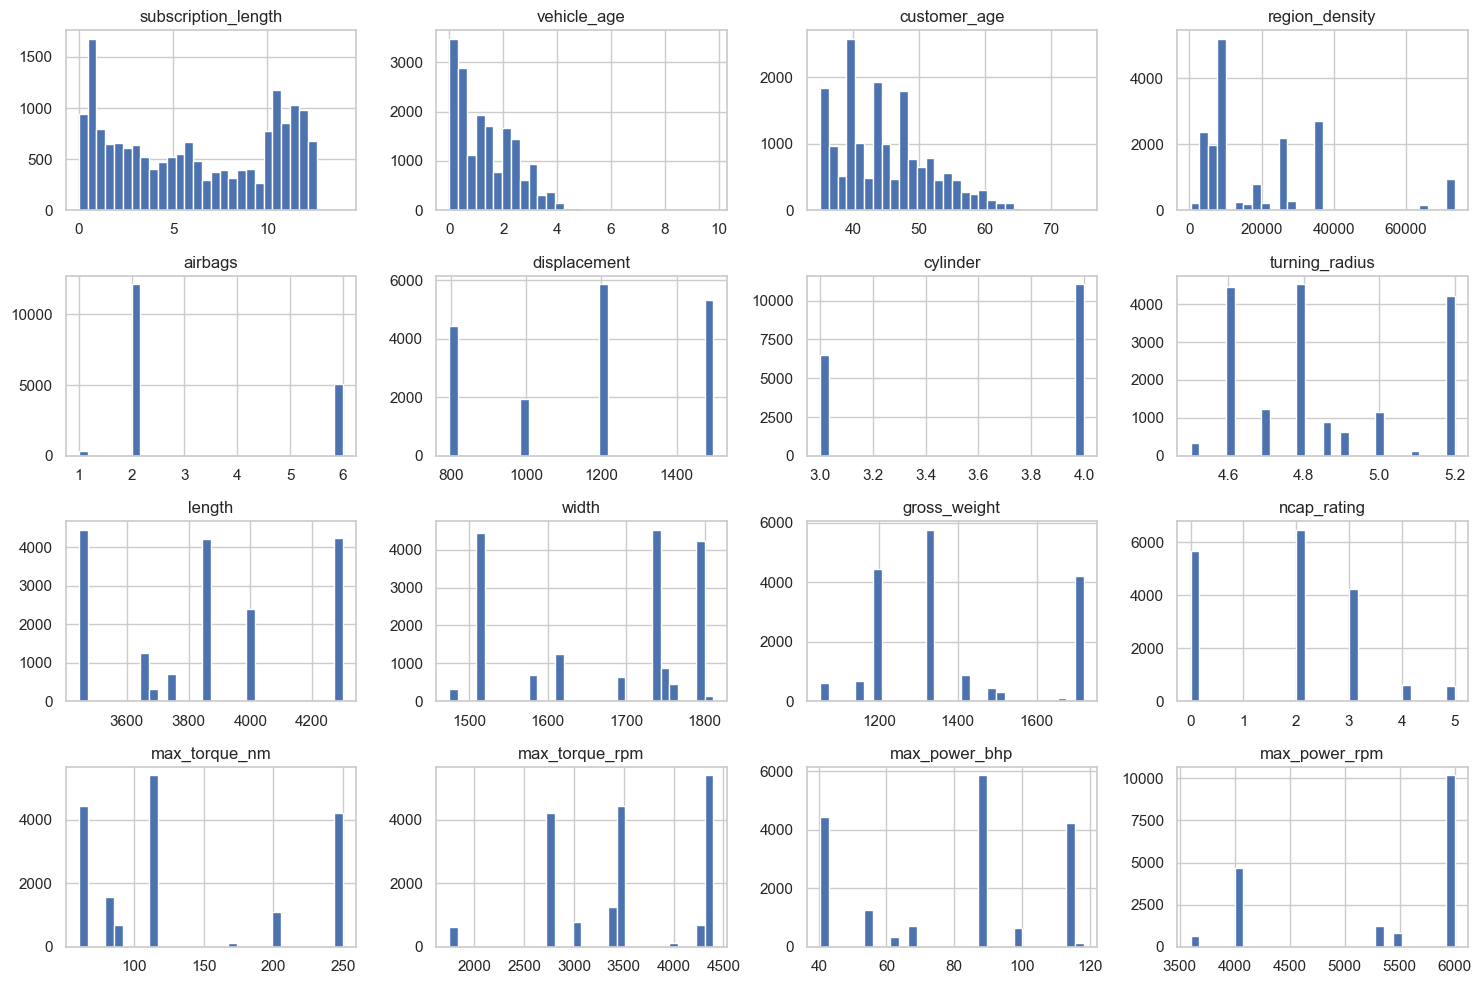

In [7]:
df_pd_num.hist(bins=30, figsize=(15,10))
plt.tight_layout()
plt.show()

### Categorical features analysis

In [8]:
cat_cols_viz = [
    "fuel_type", 
    "transmission_type",
    "segment",
    "steering_type",
    "engine_type",
    "rear_brakes_type"
]


In [9]:
def collect_cat_stats(df, cat_cols):

    result_tables = []

    for col_name in cat_cols:
        tbl = (
            df.groupBy(col_name)
              .agg(
                  F.sum(F.col("claim_status")).alias("count_1"),
                  F.sum(F.when(F.col("claim_status") == 0, 1).otherwise(0)).alias("count_0"),
                  F.count("*").alias("total")
              )
              .withColumn("claim_rate", F.col("count_1") / F.col("total"))
              .withColumn("feature", F.lit(col_name))
              .withColumnRenamed(col_name, "category")
        )
        result_tables.append(tbl)

    final = result_tables[0]
    for tbl in result_tables[1:]:
        final = final.unionByName(tbl)

    return final


In [10]:
cat_stats_df = collect_cat_stats(df, cat_cols_viz)  
cat_stats_pd = cat_stats_df.toPandas()

In [11]:
print(cat_stats_pd)

                     category  count_1  count_0  total  claim_rate            feature
0                      Diesel     1150    16580  17730    0.064862          fuel_type
1                         CNG     1235    19095  20330    0.060748          fuel_type
2                      Petrol     1363    19169  20532    0.066384          fuel_type
3                   Automatic     1310    19101  20411    0.064181  transmission_type
4                      Manual     2438    35743  38181    0.063854  transmission_type
5                          B2     1256    17058  18314    0.068581            segment
6                          B1      244     3929   4173    0.058471            segment
7                           A     1046    16275  17321    0.060389            segment
8                     Utility       73     1136   1209    0.060380            segment
9                          C1      228     3329   3557    0.064099            segment
10                         C2      901    13117  14018

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

def plot_vertical_categorical_subplots(
    cat_stats_pd,
    layout=(2, 3),
    figsize=(18, 10),
    rotation=45
):

    features = cat_stats_pd["feature"].unique()
    n = len(features)

    rows, cols = layout
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    global_min = cat_stats_pd["claim_rate"].min()
    global_max = cat_stats_pd["claim_rate"].max()
    norm = colors.Normalize(vmin=global_min, vmax=global_max)
    cmap = cm.viridis

    for idx, feature in enumerate(features):
        ax = axes[idx]

        data = cat_stats_pd[cat_stats_pd["feature"] == feature]

        rates = data["claim_rate"].values
        colors_list = cmap(norm(rates))

        ax.bar(data["category"], rates, color=colors_list)

        if feature == "engine_type":
            ax.tick_params(axis="x", rotation=45, labelsize=7)
        else:
            ax.tick_params(axis="x", rotation=40, labelsize=10)

        ax.set_title(feature, fontsize=12)
        ax.set_ylabel("Claim Rate")
        ax.margins(x=0.05)

    for i in range(idx + 1, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


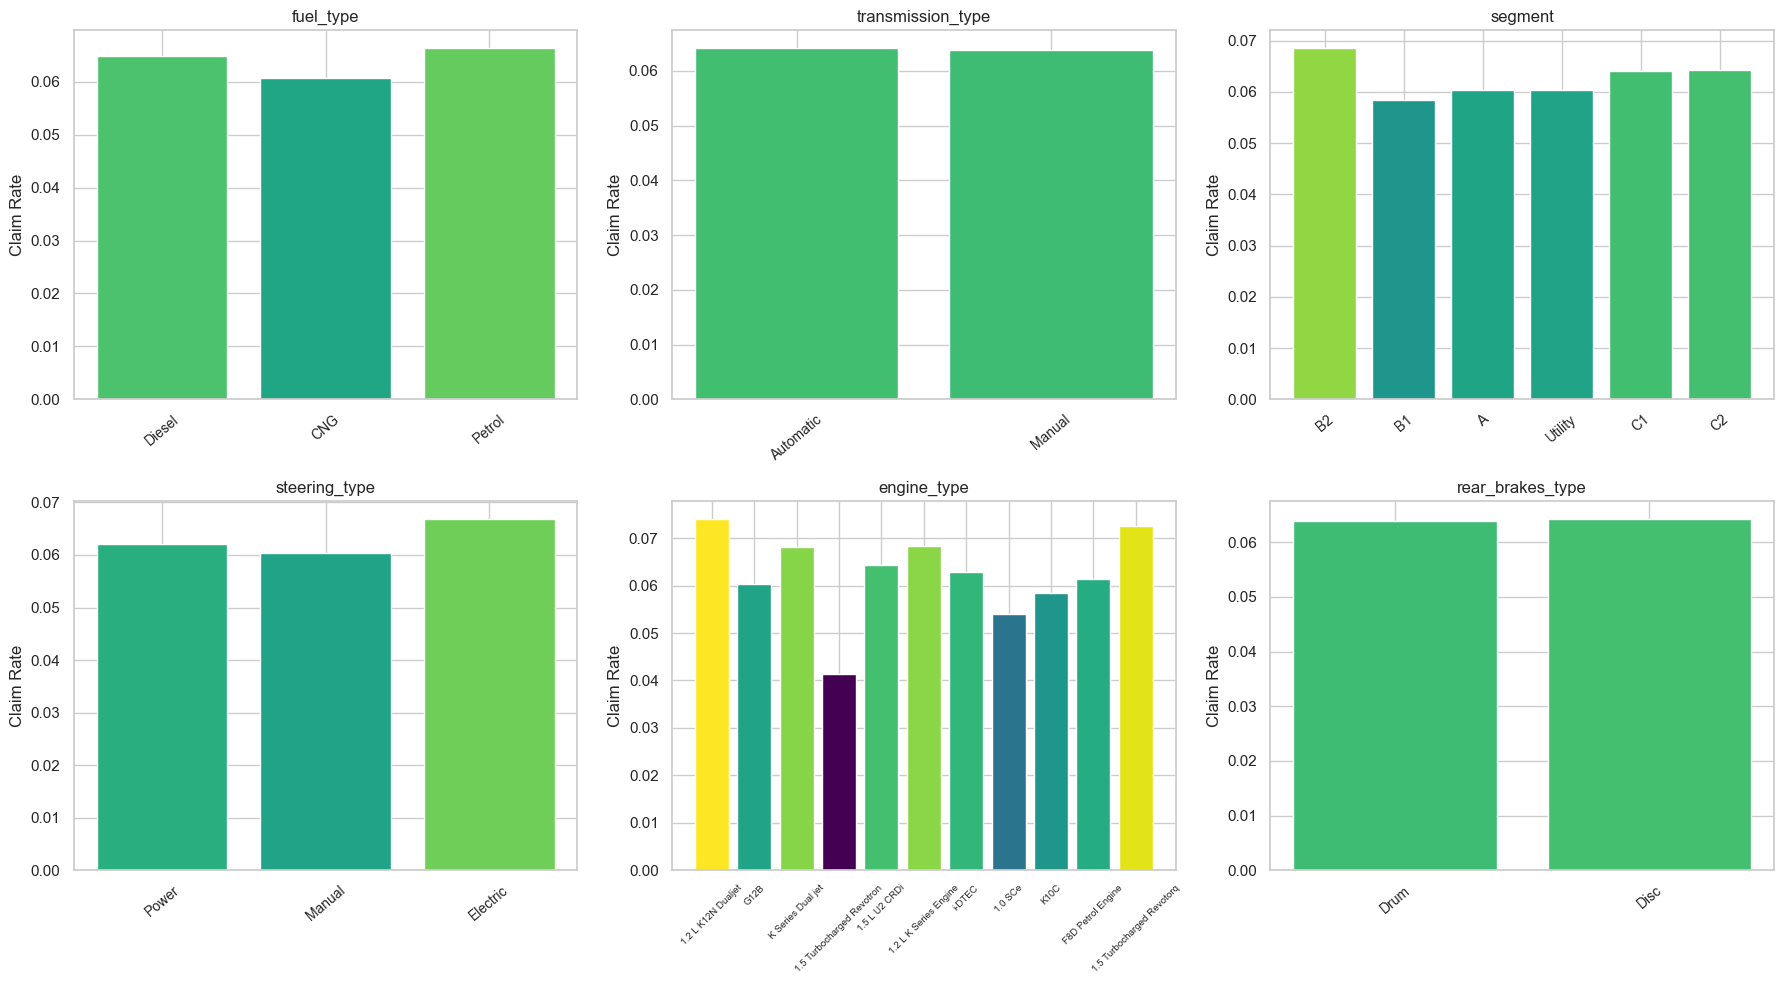

In [13]:
plot_vertical_categorical_subplots(cat_stats_pd)

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.stat import ChiSquareTest

def chi_square_for_categoricals(df, categorical_cols, target_col="claim_status"):

    results = []

    for col_name in categorical_cols:

        indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_idx")
        df_i = indexer.fit(df).transform(df)

        encoder = OneHotEncoder(inputCols=[f"{col_name}_idx"], 
                                outputCols=[f"{col_name}_vec"])
        df_e = encoder.fit(df_i).transform(df_i)

        assembler = VectorAssembler(inputCols=[f"{col_name}_vec"], 
                                    outputCol="features")
        df_vec = assembler.transform(df_e).select("features", target_col)

        chi_res = ChiSquareTest.test(df_vec, "features", target_col).head()

        results.append((
            col_name,
            float(chi_res.pValues.min()),
            float(chi_res.statistics.sum()),
            int(sum(chi_res.degreesOfFreedom))
        ))

    import pandas as pd
    res_df = pd.DataFrame(results, 
                          columns=["feature", "p_value", "chi_square", "degrees_of_freedom"])
    return res_df


In [23]:
chi_df = chi_square_for_categoricals(df, cat_cols_viz)
chi_df

,feature,p_value,chi_square,degrees_of_freedom
0,fuel_type,0.020237,8.473751,2
1,transmission_type,0.877393,0.023801,1
2,segment,0.002088,17.027640,5
3,steering_type,0.017127,10.609287,2
4,engine_type,0.021429,19.152263,10
5,rear_brakes_type,0.864887,0.028953,1


### Correlation matrix

In [15]:
numeric_cols = [
    "subscription_length",
    "vehicle_age",
    "customer_age",
    "region_density",
    "airbags",
    "displacement",
    "cylinder",
    "turning_radius",
    "length",
    "width",
    "gross_weight",
    "max_torque_nm",
    "max_torque_rpm",
    "max_power_bhp",
    "max_power_rpm",
    "claim_status"
]
df_pd_numeric = df.select(numeric_cols).sample(False, 0.3, seed=0.42).toPandas()

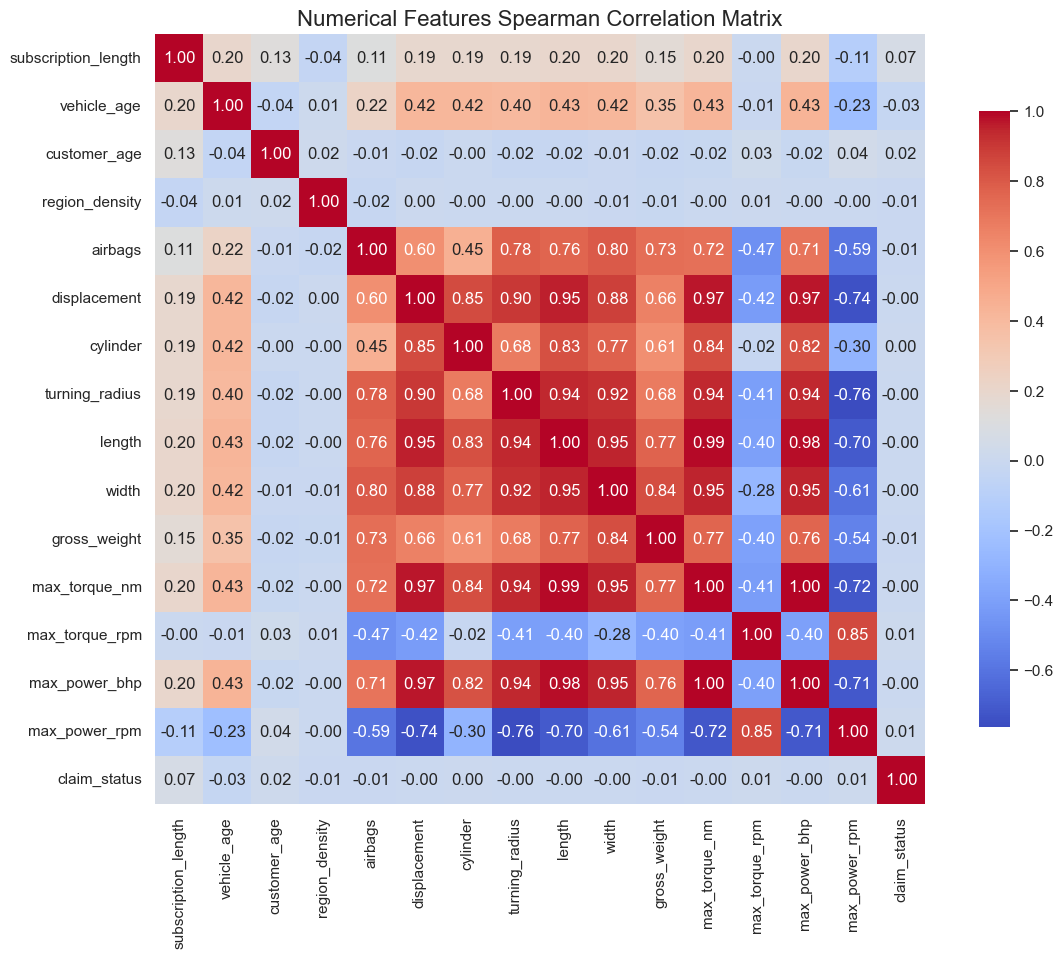

In [17]:
corr = df_pd_numeric.corr(method='spearman')
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Numerical Features Spearman Correlation Matrix", fontsize=16)
plt.show()

### Summary of EDA findings:

- Numeric features show significant multicollinearity (engine specs highly correlated).

- Numeric features have no strong linear relationship with the target.

- Categorical features (segment, steering_type, fuel_type, engine_type, rear_brakes_type) show noticeable differences in claim rates.

- New engineered numeric features may be necessary to improve signal.

- No major outliers or data quality issues remain after preprocessing.
